## Calculating Carbon Stock (updated)

In [2]:
##load data from database

# === 1. Imports ===
import pandas as pd
from sqlalchemy import create_engine

# === 2. Connect to PostgreSQL ===
# Replace with your actual credentials
USER = "inesschwartz"
PASSWORD = "aa4862aa"
HOST = "localhost"
PORT = "5432"
DB = "soils_angola"

engine = create_engine(f"postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DB}")

# === 3. Load data from each table ===
# You can filter early to avoid huge pulls
analyses = pd.read_sql("SELECT * FROM analyses", engine)
morpho = pd.read_sql("SELECT * FROM morpho", engine)
site_info = pd.read_sql("SELECT * FROM site_info", engine)
soil_type = pd.read_sql("SELECT * FROM soil_type", engine)
samples = pd.read_sql("SELECT * FROM samples", engine)
usable_sites = pd.read_sql("SELECT * FROM usable_site_info", engine)
climate_feat = pd.read_sql("SELECT * FROM climate_feat", engine)

# === 4. CREATE MERGED DATASET ===

# Columns to select from analyses
analyses_cols = [
    'analysis_id', 'morpho_id', 'sample_id', 'profile', 'upper_depth', 'lower_depth',
    'thick_sand', 'fine_sand', 'silt', 'clay', 'atm_15', 'free_iron', 
    'organic_carbon', 'p205', 'organic_material', 'ph_h2o', 'ph_kcl', 
    'exchangable_bases_sum', 'cec', 'sample_depth', 'bulk_density', 'porosity'
]

# Subset analyses to relevant columns, ignoring missing cols gracefully
analyses_subset = analyses[[col for col in analyses_cols if col in analyses.columns]].copy()

# Filter analyses and morpho to only profiles present in site_info
valid_profiles = site_info['profile'].dropna().unique()

analyses_filtered = analyses_subset[analyses_subset['profile'].isin(valid_profiles)]
morpho_filtered = morpho[morpho['profile'].isin(valid_profiles)]

# Ensure matching dtypes for merge keys
analyses_filtered['sample_id'] = analyses_filtered['sample_id'].astype(str)
morpho_filtered['sample_id'] = morpho_filtered['sample_id'].astype(str)  # optional, since already object

# Now merge
combined_data = pd.merge(
    analyses_filtered,
    morpho_filtered,
    on=['profile', 'sample_id'],
    how='outer',
    suffixes=('', '_morpho')
)


# Inner join with site_info to keep only profiles with site info
merged_final = pd.merge(
    combined_data,
    site_info,
    on='profile',
    how='inner'
)

# Now merge with samples to add 'year' by sample_id
# Assuming 'samples' DataFrame is loaded and has 'sample_id' and 'year' columns
merged_final = pd.merge(
    merged_final,
    samples[['sample_id', 'year']],
    on='sample_id',
    how='inner'
)


Preparing harmonized SOC stock (0–30 cm) according to FAO guidelines, including coarse fragment corrections, spline harmonization, uncertainty propagation, and visualization.

**A Note on Course fragments**

Coarse fragment contents were harmonized from qualitative field descriptions into quantitative percentage ranges using established abundance classes from international soil classification systems (FAO, 2006; IUSS Working Group WRB, 2022; USDA Soil Survey Manual, 2017). Terms such as raro, algum, bastante, muito, abundante, predomínio, and abundantíssimo were aligned with standard volumetric classes of rock fragments: e.g., algum/pouco (<10%), bastante (10–25%), muito (25–45%), abundante (45–55%), predomínio (55–80%), abundantíssimo (>80%), with rare or accidental occurrences assigned 0–2%. When descriptors included ranges (e.g., algum a bastante), the span of the two classes was used, while combinations with e (e.g., muito e algum) were treated as mixtures, with the overall minimum and maximum retained. For each description, a low, high, and midpoint (%) estimate was derived, ensuring both reproducibility and uncertainty tracking in soil organic carbon stock calculations.

References

FAO (2006). Guidelines for Soil Description (4th ed.). FAO, Rome.

IUSS Working Group WRB (2022). World Reference Base for Soil Resources, International soil classification system for naming soils and creating legends for soil maps. 4th edition. IUSS, Vienna.

Soil Survey Staff (2017). Soil Survey Manual. USDA Handbook 18, Washington, D.C.

In [3]:
# dealing with mapping thick_contents_count to a course fragment percentage

import pandas as pd
import numpy as np
import re

# Base mapping: Portuguese terms → (low, high, midpoint)
base_classes = {
    "rarissimo": (0, 2, 1),
    "acidental": (0, 2, 1),
    "raro": (0, 5, 2.5),
    "pouco": (0, 10, 5),
    "algum": (0, 10, 5),
    "bastante": (10, 25, 17.5),
    "muito": (25, 45, 35),
    "abundante": (45, 55, 50),
    "abundantes": (45, 55, 50),
    "abundantissimo": (80, 90, 85),
    "predominio": (55, 80, 67.5),
    "ligeiro predominio": (45, 55, 50),
    "partes sensivelmente iguais": (45, 55, 50),
}

def parse_frag_label(label):
    if pd.isna(label) or str(label).strip() == "" or label.strip() == "0":
        return (0, 0, 0)

    s = str(label).lower()
    # collect all known terms in string
    matches = [v for k, v in base_classes.items() if k in s]

    if not matches:
        return (np.nan, np.nan, np.nan)

    lows = [m[0] for m in matches]
    highs = [m[1] for m in matches]

    low, high = min(lows), max(highs)
    mid = (low + high) / 2
    return (low, high, mid)

# apply to dataframe
merged_final[["frag_low", "frag_high", "frag_mid"]] = (
    merged_final["thick_contents_count"]
    .apply(parse_frag_label)
    .apply(pd.Series)
)


## Calculate SOC Stock according to FAO procedures 


Script takes raw soil profile data, harmonizes SOC values to a standard depth interval (0–30 cm) using a mass-preserving spline, corrects for coarse fragments, calculates per-profile SOC stocks, and outputs a clean harmonized dataset.


FAO uses R not python, so functions changed accordingly

In [4]:
# 0) Imports
# ----------------------------------------
import pandas as pd
import numpy as np
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# ------------------------------
# Suppress minor spline warnings
# ------------------------------
warnings.filterwarnings("ignore", category=UserWarning)

# ------------------------------
# 1) Specify dataset
# ------------------------------
SOC_dataset = merged_final[['site_info_id', 'analysis_id', 'profile',
                            'upper_depth', 'lower_depth', 'organic_carbon',
                            'X_coord', 'Y_coord', 'bulk_density',
                            'frag_mid']].copy()  # only use mid CF for horizon correction

# Harmonize organic carbon units (percent) (is this turning organic_carbon into a percent and then calling it SOC?)
SOC_dataset["soc_percent"] = SOC_dataset["organic_carbon"].apply(
    lambda x: x/10 if x > 50 else x
)

# ------------------------------
# 2) Mass-preserving spline for SOC only (FAO recommendation)
# ------------------------------
def fit_mpspline(depth_top, depth_bottom, values, lam=1.0, target_depths=[0,30]):
    depth_top = np.array(depth_top)
    depth_bottom = np.array(depth_bottom)
    values = np.array(values)
    
    # Remove NaNs
    mask = ~np.isnan(depth_top) & ~np.isnan(depth_bottom) & ~np.isnan(values)
    depth_top = depth_top[mask]
    depth_bottom = depth_bottom[mask]
    values = values[mask]
    
    n = len(values)
    if n == 0:
        return np.nan
    elif n == 1:
        return values[0]
    elif n == 2:
        thickness = depth_bottom - depth_top
        return np.average(values, weights=thickness)
    
    # Compute midpoints and sort
    midpoints = (depth_top + depth_bottom) / 2
    sort_idx = np.argsort(midpoints)
    midpoints = midpoints[sort_idx]
    values = values[sort_idx]
    
    # Remove duplicate midpoints
    unique_midpoints, unique_indices = np.unique(midpoints, return_index=True)
    values = values[unique_indices]
    
    k = min(3, len(values)-1)
    spline = UnivariateSpline(unique_midpoints, values, s=lam, k=k)
    
    top, bottom = target_depths
    integral = spline.integral(top, bottom)
    return integral / (bottom - top)

# ------------------------------
# ------------------------------
# 3) Harmonize profiles and calculate SOC stock
# ------------------------------
profiles = SOC_dataset['profile'].unique()
harmonized_list = []

for pid in profiles:
    # Make an explicit copy of each profile slice (avoids SettingWithCopyWarning)
    profile = SOC_dataset[SOC_dataset['profile'] == pid].copy()
    
    # Skip profiles with no SOC data
    if profile['soc_percent'].isna().all():
        continue
    
    # Harmonize SOC only (0–30 cm) using spline
    soc_h = fit_mpspline(
        depth_top=profile['upper_depth'],
        depth_bottom=profile['lower_depth'],
        values=profile['soc_percent'],
        lam=1.0,
        target_depths=[0, 30]
    )
    
    # Horizon-level BD correction for coarse fragments
    profile['bd_corrected'] = profile['bulk_density'] * (1 - profile['frag_mid'] / 100)
    
    # Horizon thickness (m)
    profile['thickness_m'] = (profile['lower_depth'] - profile['upper_depth']) / 100
    
    # Horizon SOC stock (Mg C ha-1)
    profile['soc_stock_horizon'] = (
        profile['bd_corrected'] * profile['thickness_m'] * profile['soc_percent'] * 10
    )
    
    # Total SOC stock to 30 cm (sum horizons with lower_depth ≤ 30 cm)
    soc_stock_0_30 = profile.loc[profile['lower_depth'] <= 30, 'soc_stock_horizon'].sum()
    
    # Clip negatives to zero, flag if original sum was negative
    soc_stock_0_30_clipped = max(soc_stock_0_30, 0)
    flag_negative = soc_stock_0_30 < 0
    
    # Coordinates (all horizons in a profile share same coords → take first row)
    x_coord = profile["X_coord"].iloc[0]
    y_coord = profile["Y_coord"].iloc[0]
    
    # Append to results
    harmonized_list.append({
        'profile': pid,
        'soc_harmonized_percent': soc_h,
        'soc_stock_0_30cm': soc_stock_0_30_clipped,
        'flag_negative_original': flag_negative,
        'X_coord': x_coord,
        'Y_coord': y_coord
    })
    
# ------------------------------
# 4) Create final dataframe
# ------------------------------
harmonized_df = pd.DataFrame(harmonized_list)
harmonized_df.dropna(subset=['soc_harmonized_percent'], inplace=True)

# Preview
print(harmonized_df.head())
print(harmonized_df['soc_stock_0_30cm'].describe())

# ----------------------------------------
# 5) Optional: save harmonized dataset
# ----------------------------------------
harmonized_df.to_csv("/Users/inesschwartz/Desktop/cleandata/harmonized_soc_0_30cm.csv", index=False)


   profile  soc_harmonized_percent  soc_stock_0_30cm  flag_negative_original  \
0   100_56                0.723829          2.527514                   False   
1   100_58                1.229639          4.255625                   False   
2   100_59                0.755000          0.000000                   False   
4   100_63                0.353306          1.643339                   False   
6  101A_58                0.767291          2.795672                   False   

     X_coord    Y_coord  
0  16.269295 -12.580465  
1  13.950172 -12.035300  
2  12.733427  -4.627420  
4  18.115896 -11.460891  
6  13.935472 -12.058784  
count    930.000000
mean       2.815592
std        2.548913
min        0.000000
25%        1.376555
50%        2.235260
75%        3.534686
max       35.253144
Name: soc_stock_0_30cm, dtype: float64


In [7]:
harmonized_df.head()

,profile,soc_harmonized_percent,soc_stock_0_30cm,flag_negative_original,X_coord,Y_coord
0,100_56,0.723829,2.527514,False,16.269295,-12.580465
1,100_58,1.229639,4.255625,False,13.950172,-12.035300
2,100_59,0.755000,0.000000,False,12.733427,-4.627420
4,100_63,0.353306,1.643339,False,18.115896,-11.460891
6,101A_58,0.767291,2.795672,False,13.935472,-12.058784


In [9]:
# 6) Descriptive statistics for SOC percent and SOC stock

summary_stats = harmonized_df[["soc_harmonized_percent", "soc_stock_0_30cm"]].describe()
print(summary_stats)


       soc_harmonized_percent  soc_stock_0_30cm
count              930.000000        930.000000
mean                 0.688730          2.815592
std                  0.665581          2.548913
min                  0.000000          0.000000
25%                  0.324883          1.376555
50%                  0.543390          2.235260
75%                  0.851304          3.534686
max                  9.050000         35.253144


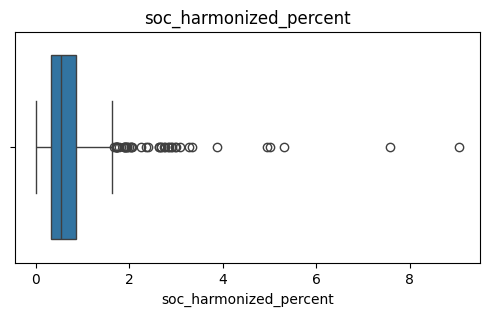

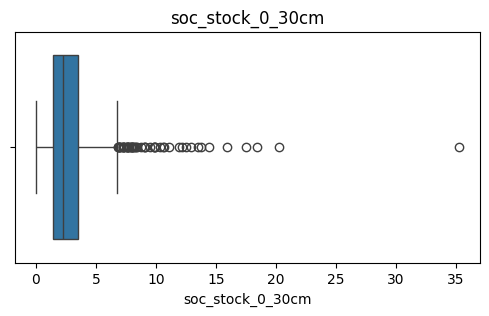

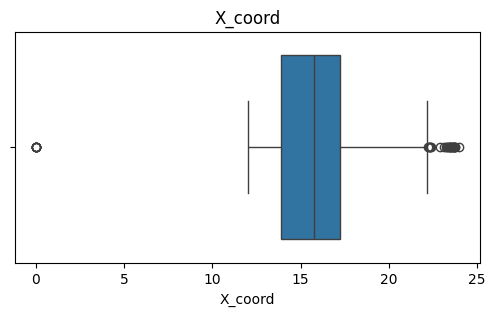

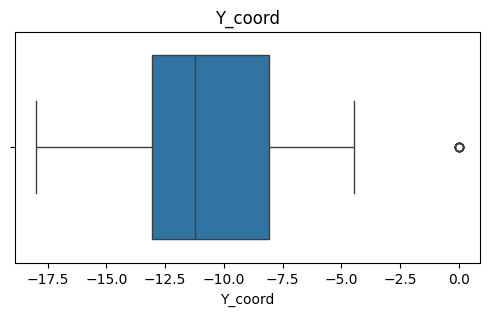

In [9]:
## identify outliers
## check for outliers
numeric_cols = harmonized_df.select_dtypes(include=['float64', 'int64']).columns
harmonized_df[numeric_cols].describe()

#IQR method
Q1 = harmonized_df[numeric_cols].quantile(0.25)
Q3 = harmonized_df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

outliers = ((harmonized_df[numeric_cols] < (Q1 - 1.5 * IQR)) | 
            (harmonized_df[numeric_cols] > (Q3 + 1.5 * IQR)))

import matplotlib.pyplot as plt
import seaborn as sns

for col in numeric_cols:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=harmonized_df[col])
    plt.title(col)
    plt.show()


1) f the log-transformation of the response variable (SOC) tends to normality; and 
2) If this transformation increases the simple correlation of SOC and its prediction factors.

In [ ]:
# make this python
# Generate a new column with the transformed OCSKGM to its natural 
# # logarithm  dat$OCSKGMlog <- log(dat$OCSKGM)  
# Plot the next two plots as one 
# par(mfrow=c(1,2))  plot(density(dat$OCSKGM),  main='Original values')  
# plot(density(dat$OCSKGMlog), main='Log-transformed values')

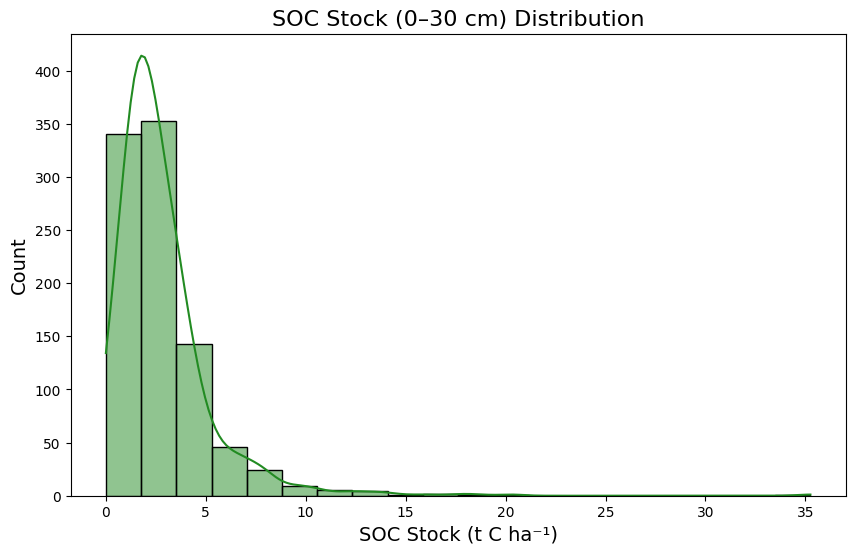

In [16]:
# 7) Histogram of SOC stock

plt.figure(figsize=(10,6))
sns.histplot(harmonized_df['soc_stock_0_30cm'], bins=20, kde=True, color='forestgreen')
plt.title('SOC Stock (0–30 cm) Distribution', fontsize=16)
plt.xlabel('SOC Stock (t C ha⁻¹)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

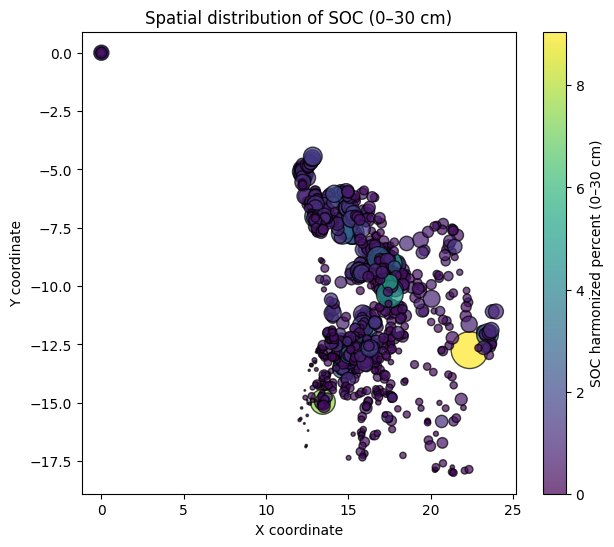

In [15]:
# 8) Scatter plot of profiles

plt.figure(figsize=(7,6))
plt.scatter(
    harmonized_df["X_coord"], harmonized_df["Y_coord"],
    s=harmonized_df["soc_stock_0_30cm"]*20,  # bubble size proportional to SOC stock
    c=harmonized_df["soc_harmonized_percent"], cmap="viridis", alpha=0.7, edgecolor="k"
)
plt.colorbar(label="SOC harmonized percent (0–30 cm)")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.title("Spatial distribution of SOC (0–30 cm)")
plt.show()


## prepare Training Data to estimate SOC stock throughout Angola

*Needs work: updating QGIS .tif files and will continue trying to extract rasters in a separate notebook*

In [1]:
# load libraries
import geopandas as gpd
import pandas as pd
from rasterstats import point_query
import os

# Load your harmonized SOC dataset (with X_coord, Y_coord)
soc_df = pd.read_csv("/Users/inesschwartz/Desktop/cleandata/harmonized_soc_0_30cm.csv")  # columns must include: profile, X_coord, Y_coord, SOC

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    soc_df,
    geometry=gpd.points_from_xy(soc_df["X_coord"], soc_df["Y_coord"]),
    crs="EPSG:32733"
)

In [2]:
## Define raster files 

dem_files = {
    "dem_hillshade": "/Volumes/One_Touch/angola_thesis_gis/GIS_Angola/data_processed/hillshade.tif",
    "dem_aspect": "/Volumes/One_Touch/angola_thesis_gis/GIS_Angola/data_processed/aspect.tif",
    "dem_aspect_classes": "/Volumes/One_Touch/angola_thesis_gis/GIS_Angola/data_processed/aspect_classes2.tif",
    "dem_slope": "/Volumes/One_Touch/angola_thesis_gis/GIS_Angola/data_processed/slope.tif",
    "dem_elevation": "/Volumes/One_Touch/angola_thesis_gis/GIS_Angola/data_processed/dem_utm.tif"
}

clim_files = {
    "clim_annual_temp": "/Volumes/One_Touch/angola_thesis_gis/GIS_Angola/data_processed/bioclimaticdata/annual_mean_temp.tif",
    "clim_temp_seasonality": "/Volumes/One_Touch/angola_thesis_gis/GIS_Angola/data_processed/bioclimaticdata/temp_seasonality.tif",
    "clim_annual_precip": "/Volumes/One_Touch/angola_thesis_gis/GIS_Angola/data_processed/bioclimaticdata/annual_precip2.tif",
    "clim_precip_seasonality": "/Volumes/One_Touch/angola_thesis_gis/GIS_Angola/data_processed/bioclimaticdata/precip_seasonality2.tif"
}

extra_files = {
    "soil_type": "/Volumes/One_Touch/angola_thesis_gis/GIS_Angola/data_processed/angola_soil_data_raster.tif",
    "lithology": "/Volumes/One_Touch/angola_thesis_gis/GIS_Angola/data_processed/lithology_rasterized.tif",
    "landform": "/Volumes/One_Touch/angola_thesis_gis/GIS_Angola/data_processed/landcover_raster.tif"
}

# Combine all rasters
all_rasters = {**dem_files, **clim_files, **extra_files}

In [3]:
# Extract raster values at points

print("Starting raster extraction at points...")

extracted_data = {}

for col_name, raster_path in all_rasters.items():
    if not os.path.exists(raster_path):
        print(f"Warning: {raster_path} does not exist, skipping.")
        continue
    
    print(f"Extracting {col_name} from {raster_path} ...")
    values = point_query(gdf, raster_path)

    # Flatten if single-band raster (dict with band numbers)
    if isinstance(values[0], dict):
        values = [v[1] for v in values]

    extracted_data[col_name] = values

print("Raster extraction completed.")

Starting raster extraction at points...
Extracting dem_hillshade from /Volumes/One_Touch/angola_thesis_gis/GIS_Angola/data_processed/hillshade.tif ...
Extracting dem_aspect from /Volumes/One_Touch/angola_thesis_gis/GIS_Angola/data_processed/aspect.tif ...
Extracting dem_aspect_classes from /Volumes/One_Touch/angola_thesis_gis/GIS_Angola/data_processed/aspect_classes2.tif ...
Extracting dem_slope from /Volumes/One_Touch/angola_thesis_gis/GIS_Angola/data_processed/slope.tif ...
Extracting dem_elevation from /Volumes/One_Touch/angola_thesis_gis/GIS_Angola/data_processed/dem_utm.tif ...
Extracting clim_annual_temp from /Volumes/One_Touch/angola_thesis_gis/GIS_Angola/data_processed/bioclimaticdata/annual_mean_temp.tif ...
Extracting clim_temp_seasonality from /Volumes/One_Touch/angola_thesis_gis/GIS_Angola/data_processed/bioclimaticdata/temp_seasonality.tif ...
Extracting clim_annual_precip from /Volumes/One_Touch/angola_thesis_gis/GIS_Angola/data_processed/bioclimaticdata/annual_precip2.ti

/opt/homebrew/lib/python3.11/site-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


Raster extraction completed.


In [5]:
#  Build final training DataFrame

training_df = soc_df.copy()  # include profile, coordinates, SOC

for col, values in extracted_data.items():
    training_df[col] = values

# Preview & sanity check

print(training_df.head())
print(training_df.info())

#  Save CSV for ML

output_csv = "/Users/inesschwartz/Desktop/cleandata//ANGOLA_SOC_training_dataset.csv"
training_df.to_csv(output_csv, index=False)
print(f"Training dataset saved to {output_csv}")

   profile  soc_harmonized_percent  soc_stock_0_30cm  flag_negative_original  \
0   100_56                0.723829          2.527514                   False   
1   100_58                1.229639          4.255625                   False   
2   100_59                0.755000          0.000000                   False   
3   100_63                0.353306          1.643339                   False   
4  101A_58                0.767291          2.795672                   False   

     X_coord    Y_coord dem_hillshade dem_aspect dem_aspect_classes dem_slope  \
0  16.269295 -12.580465          None       None               None      None   
1  13.950172 -12.035300          None       None               None      None   
2  12.733427  -4.627420          None       None               None      None   
3  18.115896 -11.460891          None       None               None      None   
4  13.935472 -12.058784          None       None               None      None   

  dem_elevation clim_annual_temp

In [6]:
print(gdf.crs)
import rasterio
with rasterio.open(dem_files['dem_hillshade']) as src:
    print(src.crs)


EPSG:32733
EPSG:32733


In [7]:
with rasterio.open(dem_files['dem_hillshade']) as src:
    print(src.bounds)


BoundingBox(left=130235.0721, bottom=7982603.9766, right=1509621.8579, top=9514640.7382)


In [8]:
print(gdf[['X_coord','Y_coord']].dtypes)
print(gdf[['X_coord','Y_coord']].isna().sum())


X_coord    float64
Y_coord    float64
dtype: object
X_coord    0
Y_coord    0
dtype: int64


In [10]:
# 🔹 Imports
import geopandas as gpd
import pandas as pd
from rasterstats import point_query
import rasterio
import os

# ------------------------------
# 1) Load harmonized SOC dataset
# ------------------------------
soc_df = pd.read_csv("/Users/inesschwartz/Desktop/cleandata/harmonized_soc_0_30cm.csv")

gdf = gpd.GeoDataFrame(
    soc_df,
    geometry=gpd.points_from_xy(soc_df["X_coord"], soc_df["Y_coord"]),
    crs="EPSG:32733"
)

# ------------------------------
# 2) Define raster files
# ------------------------------
dem_files = {
    "dem_hillshade": "/Volumes/One_Touch/angola_thesis_gis/GIS_Angola/data_processed/hillshade.tif",
    "dem_aspect": "/Volumes/One_Touch/angola_thesis_gis/GIS_Angola/data_processed/aspect.tif",
    "dem_aspect_classes": "/Volumes/One_Touch/angola_thesis_gis/GIS_Angola/data_processed/aspect_classes2.tif",
    "dem_slope": "/Volumes/One_Touch/angola_thesis_gis/GIS_Angola/data_processed/slope.tif",
    "dem_elevation": "/Volumes/One_Touch/angola_thesis_gis/GIS_Angola/data_processed/dem_utm.tif"
}

clim_files = {
    "clim_annual_temp": "/Volumes/One_Touch/angola_thesis_gis/GIS_Angola/data_processed/bioclimaticdata/annual_mean_temp.tif",
    "clim_temp_seasonality": "/Volumes/One_Touch/angola_thesis_gis/GIS_Angola/data_processed/bioclimaticdata/temp_seasonality.tif",
    "clim_annual_precip": "/Volumes/One_Touch/angola_thesis_gis/GIS_Angola/data_processed/bioclimaticdata/annual_precip2.tif",
    "clim_precip_seasonality": "/Volumes/One_Touch/angola_thesis_gis/GIS_Angola/data_processed/bioclimaticdata/precip_seasonality2.tif"
}

extra_files = {
    "soil_type": "/Volumes/One_Touch/angola_thesis_gis/GIS_Angola/data_processed/angola_soil_data_raster.tif",
    "lithology": "/Volumes/One_Touch/angola_thesis_gis/GIS_Angola/data_processed/lithology_rasterized.tif",
    "landform": "/Volumes/One_Touch/angola_thesis_gis/GIS_Angola/data_processed/landcover_raster.tif"
}

all_rasters = {**dem_files, **clim_files, **extra_files}

# ------------------------------
# 3) Function to extract raster values safely
# ------------------------------
def extract_raster_values(gdf, raster_path, col_name):
    if not os.path.exists(raster_path):
        print(f"Warning: {raster_path} not found.")
        return [None]*len(gdf)
    
    with rasterio.open(raster_path) as src:
        # Reproject points if CRS mismatch
        if gdf.crs != src.crs:
            gdf_proj = gdf.to_crs(src.crs)
        else:
            gdf_proj = gdf.copy()
        
        # Check which points fall inside raster bounds
        xmin, ymin, xmax, ymax = src.bounds
        inside_mask = (
            (gdf_proj.geometry.x >= xmin) & (gdf_proj.geometry.x <= xmax) &
            (gdf_proj.geometry.y >= ymin) & (gdf_proj.geometry.y <= ymax)
        )
        if inside_mask.sum() == 0:
            print(f"Warning: No points inside raster bounds for {col_name}.")
            return [None]*len(gdf)
        
        # Extract values
        values = point_query(gdf_proj, raster_path)
        
        # Flatten single-band rasters
        if isinstance(values[0], dict):
            values = [v[1] for v in values]
            
        return values

# ------------------------------
# 4) Extract all raster values
# ------------------------------
extracted_data = {}

print("Starting raster extraction...")
for col_name, raster_path in all_rasters.items():
    print(f"Extracting {col_name} ...")
    extracted_data[col_name] = extract_raster_values(gdf, raster_path, col_name)
print("Extraction completed.")

# ------------------------------
# 5) Build final training DataFrame
# ------------------------------
training_df = soc_df.copy()
for col, values in extracted_data.items():
    training_df[col] = values

# ------------------------------
# 6) Save CSV
# ------------------------------
output_csv = "/Users/inesschwartz/Desktop/cleandata/ANGOLA_SOC_training_dataset.csv"
training_df.to_csv(output_csv, index=False)
print(f"Training dataset saved to {output_csv}")


Starting raster extraction...
Extracting dem_hillshade ...
Extracting dem_aspect ...
Extracting dem_aspect_classes ...
Extracting dem_slope ...
Extracting dem_elevation ...
Extracting clim_annual_temp ...
Extracting clim_temp_seasonality ...
Extracting clim_annual_precip ...
Extracting clim_precip_seasonality ...
Extracting soil_type ...
Extracting lithology ...
Extracting landform ...
Extraction completed.
Training dataset saved to /Users/inesschwartz/Desktop/cleandata/ANGOLA_SOC_training_dataset.csv
